In [1]:
# !pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings

# For synthetic datasets
from sklearn.datasets import make_blobs

# For normalisation of datasets
from sklearn.preprocessing import StandardScaler

# For RoV method
from math import sqrt

# For Gaussian method
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import norm
from sklearn.decomposition import PCA

# For Agglomerative method
import scipy.cluster.hierarchy as shc

# For DeD method
from scipy.spatial.distance import mahalanobis
from scipy.stats import median_abs_deviation

# For indexes
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

In [3]:
# Ignore runtime warning
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Wine data

In [4]:
df_wine = pd.read_csv('data/wine.data', on_bad_lines='skip', sep=',')

In [5]:
headers_wine = ['title', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
           'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
           'OD280', 'Proline']
df_wine.columns = headers_wine

In [6]:
selected_columns_wine = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
           'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
           'OD280', 'Proline']

# Iris data

In [7]:
df_iris = pd.read_csv('data/iris.data', on_bad_lines='skip', sep=',')

In [8]:
headers_iris = ['sep_len', 'sep_wid', 'pet_len', 'pet_len', 'class']
df_iris.columns = headers_iris

In [9]:
selected_columns_iris = ['sep_len', 'sep_wid', 'pet_len', 'pet_len']

In [10]:
df_iris = df_iris.replace("Iris-setosa", 1)
df_iris = df_iris.replace("Iris-versicolour", 2)
df_iris = df_iris.replace("Iris-virginica", 3)

# Landsat data

In [11]:
df_landsat = pd.read_csv('data/landsat.tst', on_bad_lines='skip', sep=' ')

In [12]:
headers_landsat = [i for i in range(37)]
df_landsat.columns = headers_landsat

In [13]:
selected_columns_landsat = headers_landsat[:36]

# Magic data

In [14]:
df_magic = pd.read_csv('data/magic.data', on_bad_lines='skip', sep=',')

In [15]:
headers_magic = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym',
                 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
df_magic.columns = headers_magic

In [16]:
selected_columns_magic = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym',
                 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

# Glass data

In [17]:
df_glass = pd.read_csv('data/glass.data', on_bad_lines='skip', sep=',')

In [18]:
headers_glass = ['id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'class']
df_glass.columns = headers_glass

In [19]:
selected_columns_glass = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']

# Synthetic data

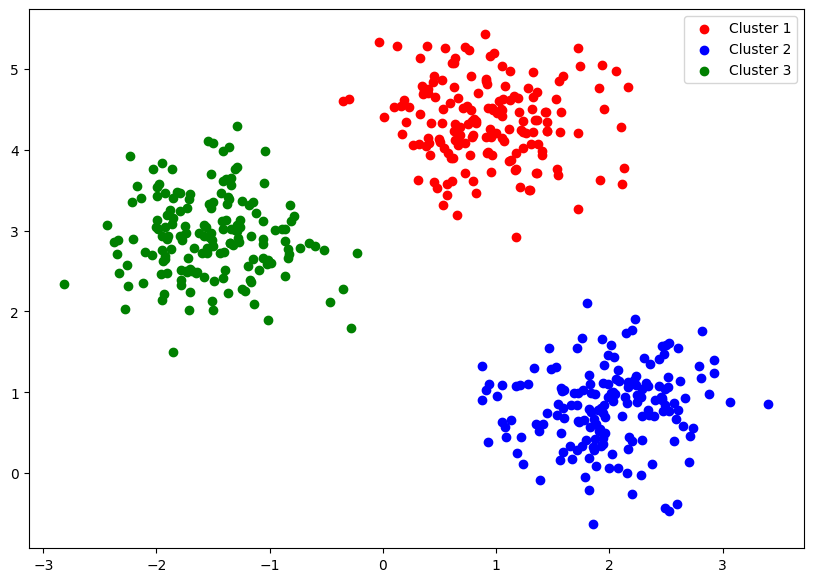

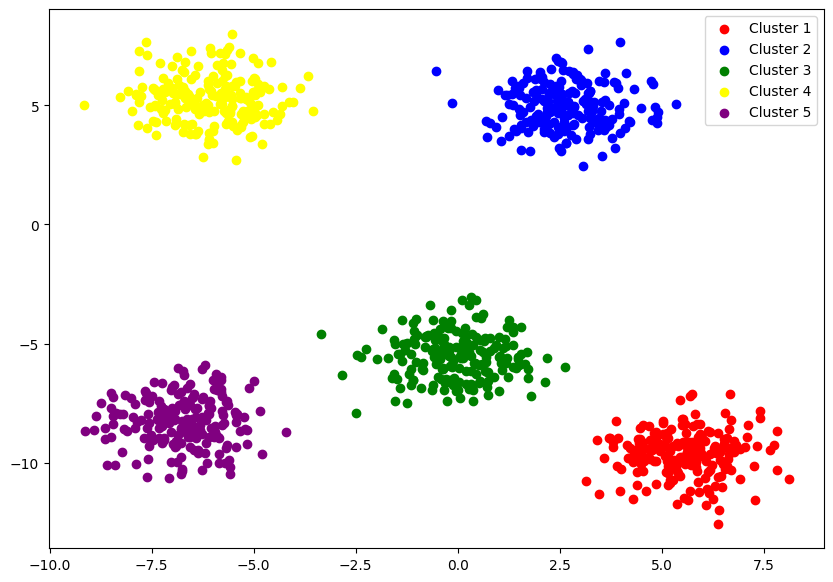

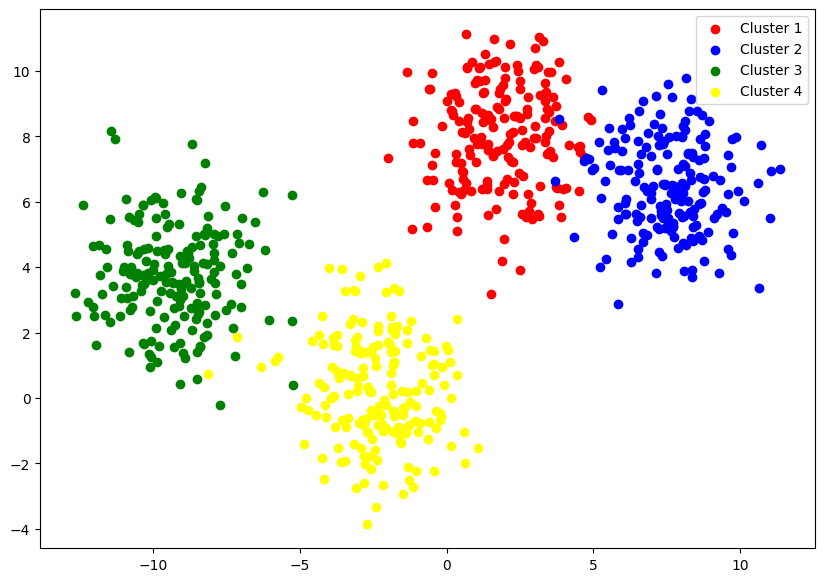

In [20]:
# Define a function to generate and plot data
def generate_and_plot_data(n_samples, centers, n_features, cluster_std, random_state):
    X, y_true = make_blobs(n_samples=n_samples, centers=centers, n_features=n_features, cluster_std=cluster_std, random_state=random_state)
    labels = y_true

    color_map = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow', 4: 'purple', 5: 'cyan', 6: 'magenta', 7: 'orange'}

    plt.figure(figsize=(10, 7))

    for i in range(len(np.unique(labels))):
        plt.scatter(X[labels == i, 0], X[labels == i, 1], color=color_map[i], label=f"Cluster {i+1}")

    plt.legend()
    plt.show()
    return X

# Now generate 5 different datasets
synth1 = generate_and_plot_data(n_samples=500, centers=3, n_features=2, cluster_std=0.5, random_state=0)
synth2 = generate_and_plot_data(n_samples=1000, centers=5, n_features=2, cluster_std=1.0, random_state=10)
synth3 = generate_and_plot_data(n_samples=750, centers=4, n_features=2, cluster_std=1.5, random_state=20)

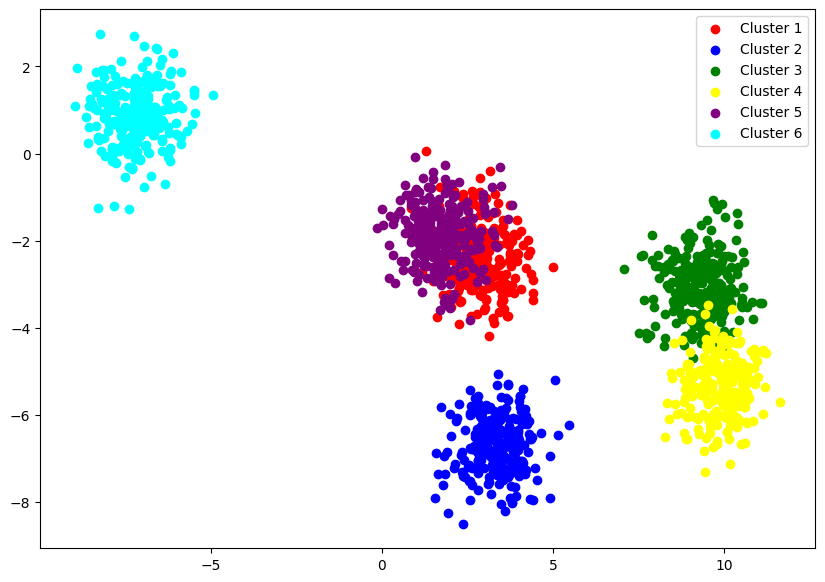

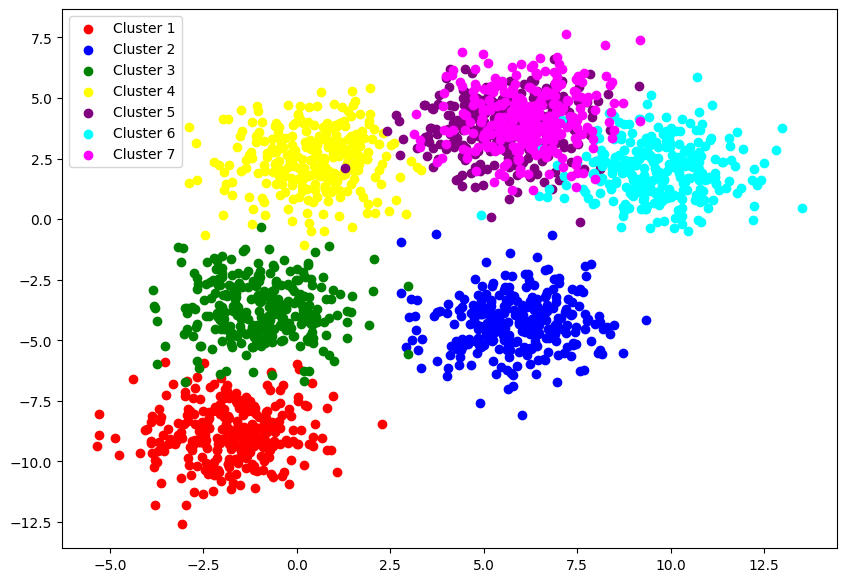

In [21]:
synth4 = generate_and_plot_data(n_samples=1500, centers=6, n_features=2, cluster_std=0.7, random_state=30)
synth5 = generate_and_plot_data(n_samples=2000, centers=7, n_features=2, cluster_std=1.2, random_state=40)

# Standart scaler

In [22]:
X_wine = df_wine[selected_columns_wine]
X_iris = df_iris[selected_columns_iris]
X_landsat = df_landsat[selected_columns_landsat]
X_magic = df_magic[selected_columns_magic]
X_glass = df_glass[selected_columns_glass]

In [23]:
scaler = StandardScaler()

In [24]:
X_wine = scaler.fit_transform(X_wine)
X_iris = scaler.fit_transform(X_iris)
X_landsat = scaler.fit_transform(X_landsat)
X_magic = scaler.fit_transform(X_magic)
X_glass = scaler.fit_transform(X_glass)

X_synth1 = scaler.fit_transform(synth1)
X_synth2 = scaler.fit_transform(synth2)
X_synth3 = scaler.fit_transform(synth3)
X_synth4 = scaler.fit_transform(synth4)
X_synth5 = scaler.fit_transform(synth5)

---

# **HSE "Sequence-based analysis of iterative anomalous clusters"**

In [25]:
def dist(p1, p2):
    return sum((p1[i] - p2[i])**2 for i in range(len(p1)))

def farthest_point(df):
    origin = [0] * (df.shape[1])
    dists = []
    for i in range(df.shape[0]):
        dists.append([list(df.iloc[i]), dist(list(df.iloc[i]), origin)])
    dists.sort(key=lambda x: x[1], reverse=True)
    return dists[0][0]

def anom_clust(df, origin):
    if origin == '0':
        origin = [0] * (df.shape[1])
    else:
        origin = list(df.mean())
    c = farthest_point(df)
    cluster = pd.Series(index=range(df.shape[0]))
    while True:
        for i in range(len(df)):
            currpoint = list(df.iloc[i])
            if dist(currpoint, c) < dist(currpoint, origin):
                cluster[i] = 1
        cnew = []
        for i in df.columns:
            cnew.append(df.loc[(cluster == 1).values][i].mean())
        if c == cnew:
            break
        c = cnew
        cluster = pd.Series(index=range(df.shape[0]))
    return cluster, c

def BatchK_Means(df, centers):
    clusters = pd.Series(index=range(df.shape[0]))
    while True:
        for i in range(len(df)):
            currentity = list(df.iloc[i])
            dists = []
            for j in range(len(centers)):  
                dists.append([j, dist(currentity, centers[j])])
            dists.sort(key=lambda x: x[1])
            clusters[i] = dists[0][0]
        cnew = [0] * len(centers)
        for i in range(len(cnew)):
            newcenter = []
            for j in df.columns:
                newcenter.append(df.loc[(clusters == i).values][j].mean())
            cnew[i] = newcenter
        if centers == cnew:
            break
        centers = cnew
        clusters = pd.Series(index=range(df.shape[0]))
    return clusters, centers
    

def IK_Means(df, origin):
    I = df
    t = 1
    k = 1
    anom_clusters = []
    centers = []
    while not I.empty:
        S, c = anom_clust(I, origin)
        I = pd.concat([I, I.iloc[(S == 1).values]]).drop_duplicates(keep=False)
        k += 1
#         print(sum(S), c)
        if S.sum() > t:
            anom_clusters.append([S, c])
    anom_clusters.sort(key=lambda x: x[0].sum(), reverse=True)
    centers = [anom_clusters[0][1]]
    for i in range(1, len(anom_clusters)):
        if anom_clusters[i][0].sum() > anom_clusters[i - 1][0].sum() * 0.6:
            centers.append(anom_clusters[i][1])
    return BatchK_Means(df, centers)

def anom_res(X, name):
    anomwine, anomwinecent = IK_Means(X, "0")
    return f"Optimal number of clusters for {name} is: {len(pd.unique(anomwine))}"

In [26]:
X_wine_df = pd.DataFrame(X_wine)
X_iris_df = pd.DataFrame(X_iris)
X_landsat_df = pd.DataFrame(X_landsat)
X_magic_df = pd.DataFrame(X_magic)
X_glass_df = pd.DataFrame(X_glass)

print(anom_res(X_wine_df, 'wine'))
print(anom_res(X_iris_df, 'iris'))
print(anom_res(X_landsat_df, 'landsat'))
print(anom_res(X_magic_df, 'magic'))
print(anom_res(X_glass_df, 'glass'))

Optimal number of clusters for wine is: 7
Optimal number of clusters for iris is: 3
Optimal number of clusters for landsat is: 14
Optimal number of clusters for magic is: 6
Optimal number of clusters for glass is: 8


In [27]:
X_synth1_df = pd.DataFrame(X_synth1)
X_synth2_df = pd.DataFrame(X_synth2)
X_synth3_df = pd.DataFrame(X_synth3)
X_synth4_df = pd.DataFrame(X_synth4)
X_synth5_df = pd.DataFrame(X_synth5)

print(anom_res(X_synth1_df, 'synth1'))
print(anom_res(X_synth2_df, 'synth2'))
print(anom_res(X_synth3_df, 'synth3'))
print(anom_res(X_synth4_df, 'synth4'))
print(anom_res(X_synth5_df, 'synth5'))

Optimal number of clusters for synth1 is: 4
Optimal number of clusters for synth2 is: 6
Optimal number of clusters for synth3 is: 4
Optimal number of clusters for synth4 is: 8
Optimal number of clusters for synth5 is: 5


# Determine Cluster Number Without Clustering for Every K Based on Ratio of Variance to Range in K-Means

In [28]:
def clustering_with_dwr(Y):
    # Compute the maximum number of clusters for KMeans
    max_clusters = int(sqrt(Y.shape[0] / 2))
    
    distortions = [] # Store distortions for each different number of clusters
    for i in range(1, max_clusters + 1):
        # Apply KMeans with different numbers of clusters
        kmeans = KMeans(n_clusters=i, n_init=10).fit(Y)
        # Append distortions (inertia_)
        distortions.append(kmeans.inertia_)
    
    # Find the optimal number of clusters using the "elbow point" of the distortion graph
    K_star = find_elbow_point(np.array(distortions))
    
    # Apply the clustering algorithm again with the optimal number of clusters
    kmeans = KMeans(n_clusters=K_star, n_init=10).fit(Y)
    C_star = kmeans.labels_
    
    return K_star, C_star

def find_elbow_point(G):
    # This function finds the point of maximum curvature from the line defined by the first and last points.
    n_points = len(G)
    coords = np.vstack((range(n_points), G)).T
    first_point = coords[0]
    line = np.subtract(coords[-1], first_point)
    line_norm = line / np.sqrt(np.sum(line**2))
    vec_from_first = np.subtract(coords, first_point)
    scalar_product = np.sum(vec_from_first * np.tile(line_norm, (n_points, 1)), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_norm)
    vector_to_line = np.subtract(vec_from_first, vec_from_first_parallel)
    dist_to_line = np.sqrt(np.sum(vector_to_line ** 2, axis=1))
    idx_of_elbow = np.argmax(dist_to_line)
    return idx_of_elbow + 1

In [29]:
K_star, C_star = clustering_with_dwr(X_wine)
print("Optimal number of clusters for wine is:", K_star)

K_star, C_star = clustering_with_dwr(X_iris)
print("Optimal number of clusters for iris is:", K_star)

K_star, C_star = clustering_with_dwr(X_landsat)
print("Optimal number of clusters for landsat is:", K_star)

K_star, C_star = clustering_with_dwr(X_magic)
print("Optimal number of clusters for magic is:", K_star)

K_star, C_star = clustering_with_dwr(X_glass)
print("Optimal number of clusters for glass is:", K_star)

Optimal number of clusters for wine is: 3
Optimal number of clusters for iris is: 2
Optimal number of clusters for landsat is: 6
Optimal number of clusters for magic is: 13
Optimal number of clusters for glass is: 5


In [30]:
K_star, C_star = clustering_with_dwr(X_synth1)
print("Optimal number of clusters for synth1 is:", K_star)

K_star, C_star = clustering_with_dwr(X_synth2)
print("Optimal number of clusters for synth2 is:", K_star)

K_star, C_star = clustering_with_dwr(X_synth3)
print("Optimal number of clusters for synth3 is:", K_star)

K_star, C_star = clustering_with_dwr(X_synth4)
print("Optimal number of clusters for synth4 is:", K_star)

K_star, C_star = clustering_with_dwr(X_synth5)
print("Optimal number of clusters for synth5 is:", K_star)

Optimal number of clusters for synth1 is: 3
Optimal number of clusters for synth2 is: 5
Optimal number of clusters for synth3 is: 4
Optimal number of clusters for synth4 is: 4
Optimal number of clusters for synth5 is: 6


# Gausian Likelyhood Score Method


In [31]:
def gaussian_likelihood_score(points, labels, resolution=50, pca=True):
    probability = 0
    n_clusters = len(np.unique(labels))
    for j in range(n_clusters):
        cluster_points = points[labels == j]
        if pca:
            cluster_points = PCA(1).fit_transform(cluster_points)
            centroid = np.mean(cluster_points)
            spread = np.std(cluster_points)

            rv = norm(loc=centroid, scale=spread)
            hist, bins = np.histogram(cluster_points[:, 0], bins=resolution)
            probability_pca = np.sum(rv.logpdf(bins[:-1]) * hist)
            if np.isnan(probability_pca):
                probability_pca = 0.
            probability += probability_pca
        else:
            centroid = np.mean(cluster_points, axis=0)
            spread = np.std(cluster_points, axis=0)

            rv_1 = norm(loc=centroid[0], scale=spread[0])
            rv_2 = norm(loc=centroid[1], scale=spread[1])

            hist_1, bins_1 = np.histogram(
                cluster_points[:, 0], bins=resolution)
            hist_2, bins_2 = np.histogram(
                cluster_points[:, 1], bins=resolution)

            probability_axis_1 = np.sum(rv_1.logpdf(bins_1[:-1]) * hist_1)
            if np.isnan(probability_axis_1):
                probability_axis_1 = 0.
            probability_axis_2 = np.sum(rv_2.logpdf(bins_2[:-1]) * hist_2)
            if np.isnan(probability_axis_2):
                probability_axis_2 = 0.
            probability += probability_axis_1 + probability_axis_2
    return probability


def find_best_cluster(scores):
    scores = np.array(scores)
    d = scores - np.hstack([[0], scores[:-1]])
    dd = d[1:] / (d[:-1] + 1e-10)
    if dd[0] < 0:
        dd[0] = np.inf
    optimal_number = np.argmin(dd)
    return optimal_number

In [32]:
data_wine = df_wine[selected_columns_wine].values
data_iris = df_iris[selected_columns_iris].values
data_landsat = df_landsat[selected_columns_landsat].values
data_magic = df_magic[selected_columns_magic].values
data_glass = df_glass[selected_columns_glass].values

min_clusters = 2
max_clusters = 10

def gls_scores_calc(data):
    gls_scores = []
    for i in range(min_clusters, max_clusters + 1):

        clusterer = AgglomerativeClustering(n_clusters=i).fit(data)
        labels = clusterer.labels_
        
        score = gaussian_likelihood_score(data, labels)
        gls_scores.append(score)
    
    return gls_scores

In [33]:
optimal_clusters = find_best_cluster(gls_scores_calc(data_wine)) + min_clusters
print(f'Optimal number of clusters for wine is: {optimal_clusters}')

optimal_clusters = find_best_cluster(gls_scores_calc(data_iris)) + min_clusters
print(f'Optimal number of clusters for iris is: {optimal_clusters}')

optimal_clusters = find_best_cluster(gls_scores_calc(data_landsat)) + min_clusters
print(f'Optimal number of clusters for landsat is: {optimal_clusters}')

optimal_clusters = find_best_cluster(gls_scores_calc(data_magic)) + min_clusters
print(f'Optimal number of clusters for magic is: {optimal_clusters}')

optimal_clusters = find_best_cluster(gls_scores_calc(data_glass)) + min_clusters
print(f'Optimal number of clusters for glass is: {optimal_clusters}')

Optimal number of clusters for wine is: 3
Optimal number of clusters for iris is: 9
Optimal number of clusters for landsat is: 3
Optimal number of clusters for magic is: 3
Optimal number of clusters for glass is: 5


In [34]:
optimal_clusters = find_best_cluster(gls_scores_calc(synth1)) + min_clusters
print(f'Optimal number of clusters for synth1 is: {optimal_clusters}')

optimal_clusters = find_best_cluster(gls_scores_calc(synth2)) + min_clusters
print(f'Optimal number of clusters for synth2 is: {optimal_clusters}')

optimal_clusters = find_best_cluster(gls_scores_calc(synth3)) + min_clusters
print(f'Optimal number of clusters for synth3 is: {optimal_clusters}')

optimal_clusters = find_best_cluster(gls_scores_calc(synth4)) + min_clusters
print(f'Optimal number of clusters for synth4 is: {optimal_clusters}')

optimal_clusters = find_best_cluster(gls_scores_calc(synth5)) + min_clusters
print(f'Optimal number of clusters for synth5 is: {optimal_clusters}')

Optimal number of clusters for synth1 is: 3
Optimal number of clusters for synth2 is: 5
Optimal number of clusters for synth3 is: 4
Optimal number of clusters for synth4 is: 7
Optimal number of clusters for synth5 is: 8


# Agglomerative clustering method

In [35]:
def aggl_clust(X):
    dend = shc.dendrogram(shc.linkage (X, method='ward'))
    unique_colors = set(dend['color_list'])
    optimal_number_of_clusters = len(unique_colors) - 1
    return optimal_number_of_clusters

Optimal number of clusters for wine is: 3


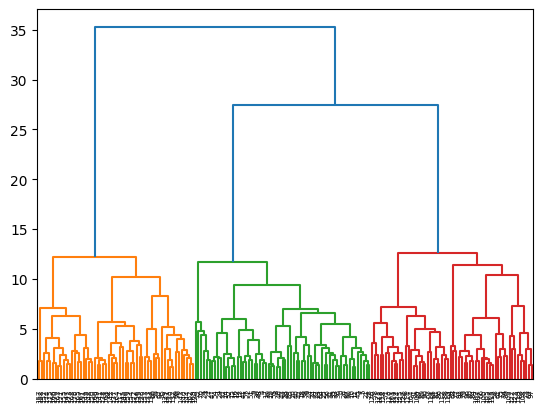

In [36]:
print(f'Optimal number of clusters for wine is: {aggl_clust(X_wine)}')

Optimal number of clusters for iris is: 2


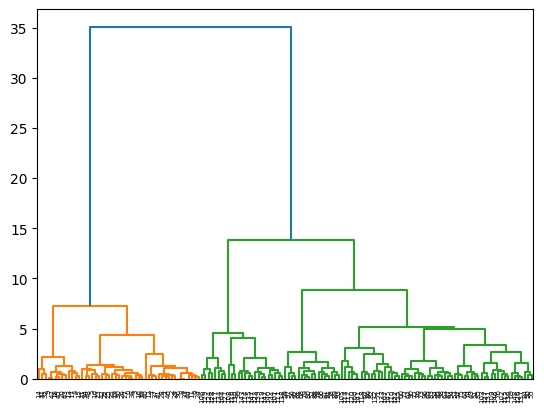

In [37]:
print(f'Optimal number of clusters for iris is: {aggl_clust(X_iris)}')

Optimal number of clusters for landsat is: 3


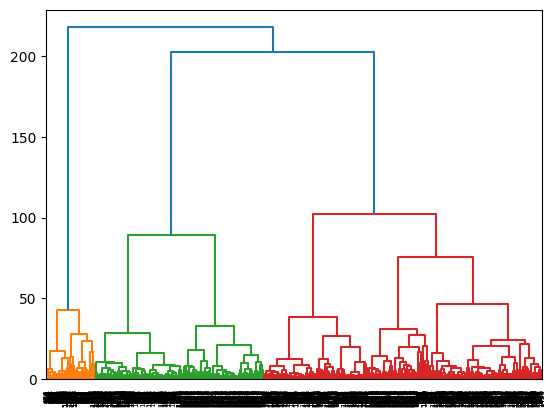

In [38]:
print(f'Optimal number of clusters for landsat is: {aggl_clust(X_landsat)}')

Optimal number of clusters for magic is:2


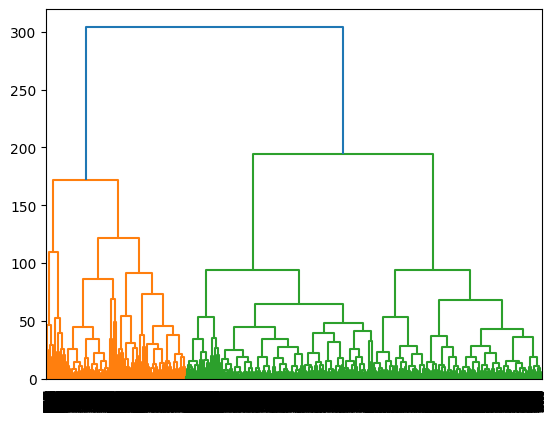

In [39]:
print(f'Optimal number of clusters for magic is:{aggl_clust(X_magic)}')

Optimal number of clusters for glass is: 4


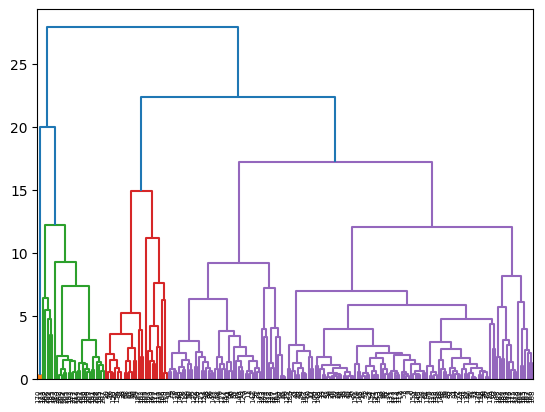

In [40]:
print(f'Optimal number of clusters for glass is: {aggl_clust(X_glass)}')

Optimal number of clusters for synth1 is: 2
Optimal number of clusters for synth2 is: 3
Optimal number of clusters for synth3 is: 2
Optimal number of clusters for synth4 is:2
Optimal number of clusters for synth5 is: 2


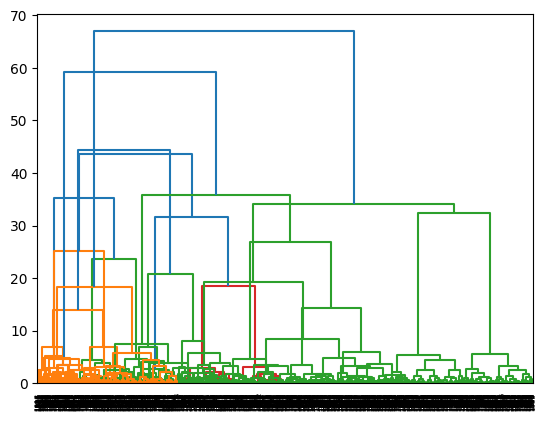

In [41]:
print(f'Optimal number of clusters for synth1 is: {aggl_clust(X_synth1)}')
print(f'Optimal number of clusters for synth2 is: {aggl_clust(X_synth2)}')
print(f'Optimal number of clusters for synth3 is: {aggl_clust(X_synth3)}')
print(f'Optimal number of clusters for synth4 is:{aggl_clust(X_synth4)}')
print(f'Optimal number of clusters for synth5 is: {aggl_clust(X_synth5)}')

# Elbow auto

In [42]:
def elbow_second_derivative(X, K_max=10):
    inertias = []
    for k in range(1, K_max+2):
        kmeans = KMeans(n_clusters=k, n_init=10).fit(X)
        inertias.append(kmeans.inertia_)

    second_derivative = [0] * (K_max - 1)
    for i in range(1, K_max):
        second_derivative[i-1] = inertias[i+1] + inertias[i-1] - 2 * inertias[i]

    optimal_k = np.argmax(second_derivative) + 2
    return optimal_k

In [43]:
print('Optimal number of clusters for wine is:',elbow_second_derivative(X_wine))
print('Optimal number of clusters for iris is:',elbow_second_derivative(X_iris))
print('Optimal number of clusters for landsat is:',elbow_second_derivative(X_landsat))
print('Optimal number of clusters for magic is:',elbow_second_derivative(X_magic))
print('Optimal number of clusters for glass is:',elbow_second_derivative(X_glass))

Optimal number of clusters for wine is: 3
Optimal number of clusters for iris is: 2
Optimal number of clusters for landsat is: 3
Optimal number of clusters for magic is: 2
Optimal number of clusters for glass is: 3


In [44]:
print('Optimal number of clusters for synth1 is:',elbow_second_derivative(X_synth1))
print('Optimal number of clusters for synth2 is:',elbow_second_derivative(X_synth2))
print('Optimal number of clusters for synth3 is:',elbow_second_derivative(X_synth3))
print('Optimal number of clusters for synth4 is:',elbow_second_derivative(X_synth4))
print('Optimal number of clusters for synth5 is:',elbow_second_derivative(X_synth5))

Optimal number of clusters for synth1 is: 2
Optimal number of clusters for synth2 is: 2
Optimal number of clusters for synth3 is: 2
Optimal number of clusters for synth4 is: 2
Optimal number of clusters for synth5 is: 2


# Elbow

In [45]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def elbow_method(X, dataset_name):
    inertia = []
    clusters = range(1, 11)

    for n in clusters:
        kmeans = KMeans(n_clusters=n, random_state=1, n_init=10).fit(X)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(6, 6))
    plt.plot(clusters, inertia, '-o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title(f'Elbow Method for {dataset_name}')
    plt.grid(True)
    plt.show()

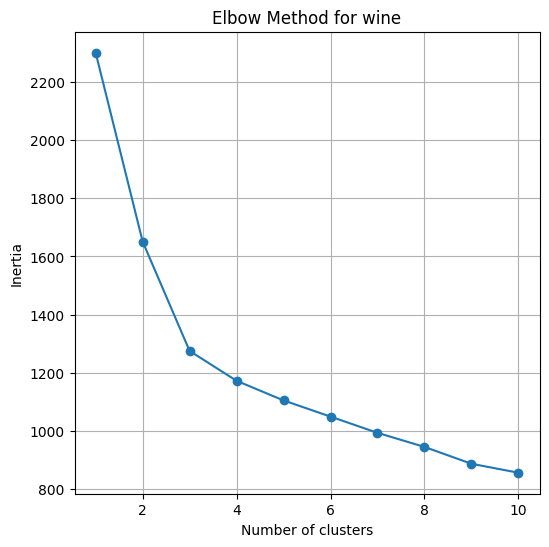

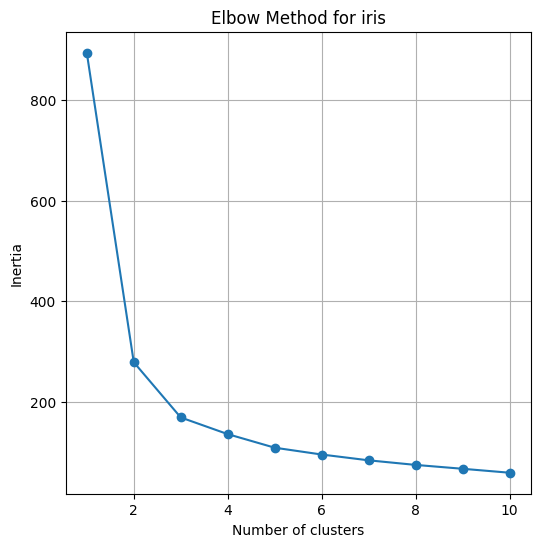

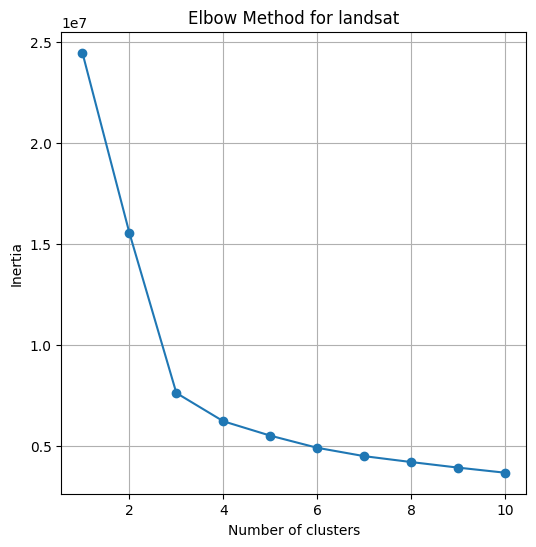

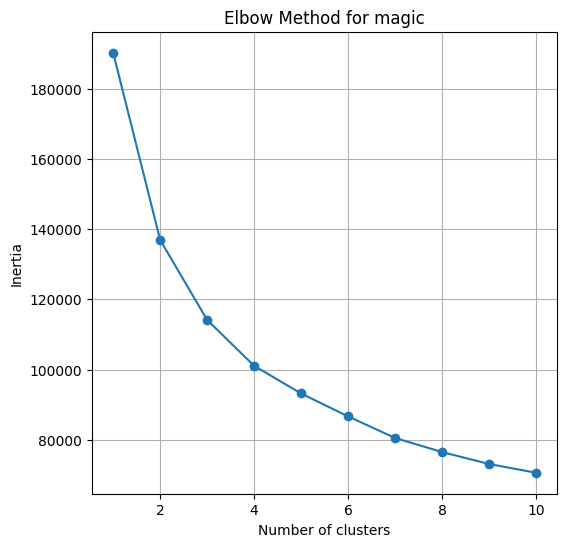

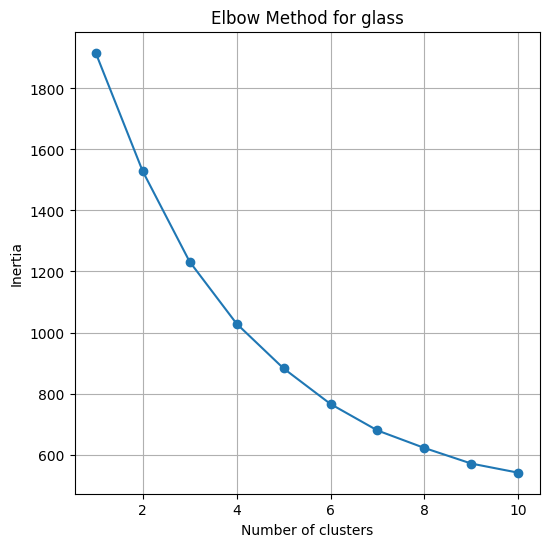

In [46]:
elbow_method(X_wine, 'wine')

elbow_method(X_iris, 'iris')

elbow_method(data_landsat, 'landsat')

elbow_method(X_magic, 'magic')

elbow_method(X_glass, 'glass')

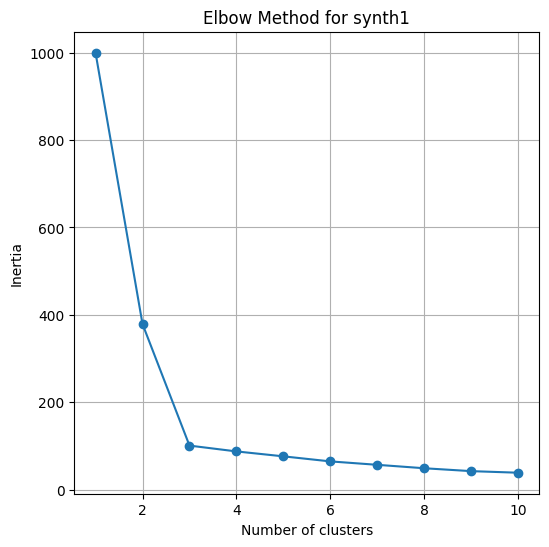

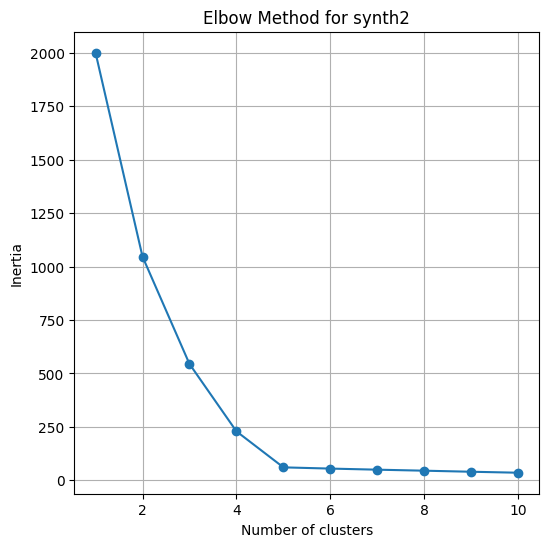

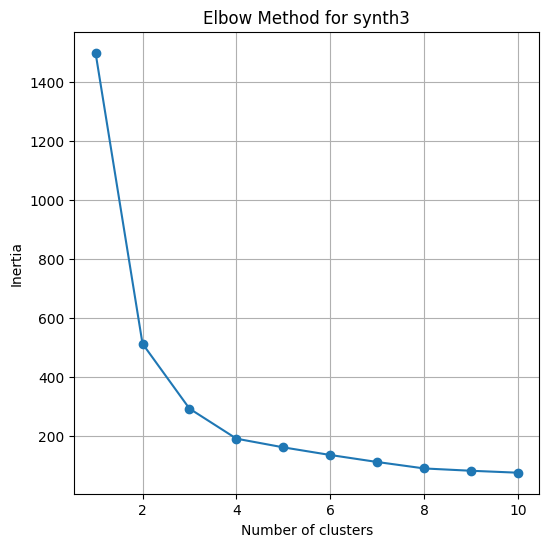

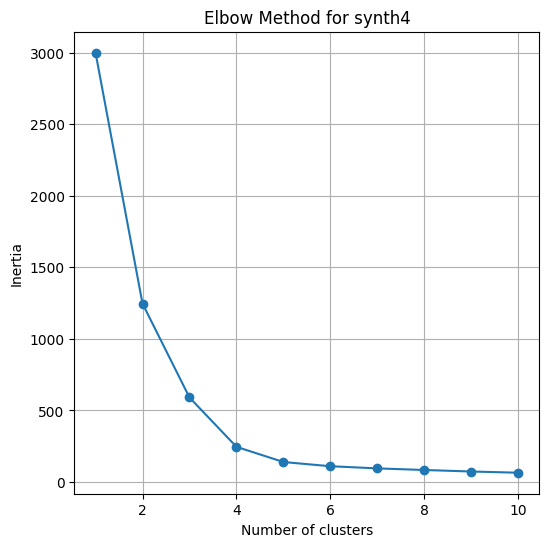

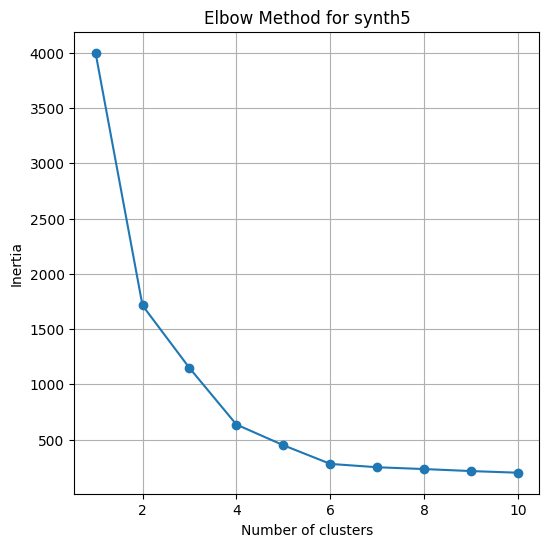

In [47]:
elbow_method(X_synth1, 'synth1')

elbow_method(X_synth2, 'synth2')

elbow_method(X_synth3, 'synth3')

elbow_method(X_synth4, 'synth4')

elbow_method(X_synth5, 'synth5')

# DeD Method

In [48]:
def calculate_mahalanobis_depth(X, xi):
    mean = np.mean(X, axis=0)
    cov = np.cov(X.T)
    pseudo_inv_cov = np.linalg.pinv(cov)
    return mahalanobis(xi, mean, pseudo_inv_cov)

def calculate_median(X):
    return np.median(X)

def estimate_number_of_clusters(X):
    n = len(X)
    Di = [calculate_mahalanobis_depth(X, xi) for xi in X]
    DM = calculate_median(Di)
    A = np.mean([abs(d - DM) for d in Di])

    max_ded = -np.inf
    optimal_k = -1
    for k in range(2, 21):
        partition_size = n // k
        start = 0
        end = 0
        Ak = []
        for j in range(1, k+1):
            start = end + 1
            end = start + partition_size - 1
            Dk = [calculate_mahalanobis_depth(X[start:end], xi) for xi in X[start:end]]
            DMk = calculate_median(Dk)
            Ak.append(np.mean([abs(d - DMk) for d in Dk]))
        DW = np.mean(Ak)
        DB = A - DW
        DED = DW - DB
        if DED > max_ded:
            max_ded = DED
            optimal_k = k
    return optimal_k

In [49]:
optimal_clusters = estimate_number_of_clusters(X_wine)
print(f"Optimal number of clusters for wine is: {optimal_clusters}")

optimal_clusters = estimate_number_of_clusters(X_iris)
print(f"Optimal number of clusters for iris is: {optimal_clusters}")

optimal_clusters = estimate_number_of_clusters(X_landsat)
print(f"Optimal number of clusters for landsat is: {optimal_clusters}")

optimal_clusters = estimate_number_of_clusters(X_magic)
print(f"Optimal number of clusters for magic is: {optimal_clusters}")

optimal_clusters = estimate_number_of_clusters(X_glass)
print(f"Optimal number of clusters for glass is: {optimal_clusters}")

Optimal number of clusters for wine is: 2
Optimal number of clusters for iris is: 3
Optimal number of clusters for landsat is: 2
Optimal number of clusters for magic is: 4
Optimal number of clusters for glass is: 4


In [50]:
optimal_clusters = estimate_number_of_clusters(X_synth1)
print(f"Optimal number of clusters for synth1 is: {optimal_clusters}")

optimal_clusters = estimate_number_of_clusters(X_synth2)
print(f"Optimal number of clusters for synth2 is: {optimal_clusters}")

optimal_clusters = estimate_number_of_clusters(X_synth3)
print(f"Optimal number of clusters for synth3 is: {optimal_clusters}")

optimal_clusters = estimate_number_of_clusters(X_synth4)
print(f"Optimal number of clusters for synth4 is: {optimal_clusters}")

optimal_clusters = estimate_number_of_clusters(X_synth5)
print(f"Optimal number of clusters for synth5 is: {optimal_clusters}")

Optimal number of clusters for synth1 is: 19
Optimal number of clusters for synth2 is: 20
Optimal number of clusters for synth3 is: 20
Optimal number of clusters for synth4 is: 3
Optimal number of clusters for synth5 is: 2


# Silhouette Algorithm

In [51]:
def optimal_clusters_via_silhouette(data, max_clusters=10):
    silhouette_scores = []

    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(data)

        labels = kmeans.labels_
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)

    best_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
    
    return best_n_clusters

In [52]:
best_n_clusters = optimal_clusters_via_silhouette(X_wine)
print(f"Optimal number of clusters for wine is: {best_n_clusters}")

best_n_clusters = optimal_clusters_via_silhouette(X_iris)
print(f"Optimal number of clusters for iris is: {best_n_clusters}")

best_n_clusters = optimal_clusters_via_silhouette(X_landsat)
print(f"Optimal number of clusters for landsat is: {best_n_clusters}")

best_n_clusters = optimal_clusters_via_silhouette(X_magic)
print(f"Optimal number of clusters for magic is: {best_n_clusters}")

best_n_clusters = optimal_clusters_via_silhouette(X_glass)
print(f"Optimal number of clusters for glass is: {best_n_clusters}")

Optimal number of clusters for wine is: 3
Optimal number of clusters for iris is: 2
Optimal number of clusters for landsat is: 3
Optimal number of clusters for magic is: 2
Optimal number of clusters for glass is: 2


In [53]:
best_n_clusters = optimal_clusters_via_silhouette(X_synth1)
print(f"Optimal number of clusters for synth1 is: {best_n_clusters}")

best_n_clusters = optimal_clusters_via_silhouette(X_synth2)
print(f"Optimal number of clusters for synth2 is: {best_n_clusters}")

best_n_clusters = optimal_clusters_via_silhouette(X_synth3)
print(f"Optimal number of clusters for synth3 is: {best_n_clusters}")

best_n_clusters = optimal_clusters_via_silhouette(X_synth4)
print(f"Optimal number of clusters for synth4 is: {best_n_clusters}")

best_n_clusters = optimal_clusters_via_silhouette(X_synth5)
print(f"Optimal number of clusters for synth5 is: {best_n_clusters}")

Optimal number of clusters for synth1 is: 3
Optimal number of clusters for synth2 is: 5
Optimal number of clusters for synth3 is: 3
Optimal number of clusters for synth4 is: 5
Optimal number of clusters for synth5 is: 6


---

# Clustering

In [137]:
def perform_kmeans_clustering(X, K):
    kmeans = KMeans(n_clusters=K, random_state=0, n_init=10)

    kmeans.fit(X)

    return kmeans.labels_

In [138]:
dbi_sum = []
dunn_sum = []
silhouette_sum = []

### Ratio of variance

In [139]:
labels_row_wine = perform_kmeans_clustering(X_wine, 3)
labels_row_iris = perform_kmeans_clustering(X_iris, 2)
labels_row_landsat = perform_kmeans_clustering(X_landsat, 6)
labels_row_magic = perform_kmeans_clustering(X_magic, 13)
labels_row_glass = perform_kmeans_clustering(X_glass, 4)

##### Davies-Bouldin

In [140]:
dbi_row_wine = davies_bouldin_score(X_wine, labels_row_wine)
dbi_row_iris = davies_bouldin_score(X_iris, labels_row_iris)
dbi_row_landsat = davies_bouldin_score(X_landsat, labels_row_landsat)
dbi_row_magic = davies_bouldin_score(X_magic, labels_row_magic)
dbi_row_glass = davies_bouldin_score(X_glass, labels_row_glass)

In [141]:
print('dbi wine', dbi_row_wine)
print('dbi iris', dbi_row_iris)
print('dbi landsat', dbi_row_landsat)
print('dbi magic', dbi_row_magic)
print('dbi glass', dbi_row_glass)

dbi wine 1.3938085497845032
dbi iris 0.5135579403975415
dbi landsat 1.0388635569037616
dbi magic 1.475520058341566
dbi glass 1.068854970613816


In [142]:
dbi_sum_row = dbi_row_wine + dbi_row_iris + dbi_row_landsat + dbi_row_magic + dbi_row_glass
dbi_sum.append(dbi_sum_row)

##### Dunn

In [143]:
def calculate_dunn(features, labels):
    unique_clusters = np.unique(labels)

    inter_cluster_distances = []
    intra_cluster_distances = []

    for cluster in unique_clusters:
        intra_cluster_points = features[labels == cluster]
        intra_cluster_distances.append(np.max(cdist(intra_cluster_points, intra_cluster_points)))

        for other_cluster in unique_clusters:
            if cluster != other_cluster:
                inter_cluster_points = features[labels == other_cluster]
                inter_cluster_distances.append(np.min(cdist(intra_cluster_points, inter_cluster_points)))

    dunn_index = np.min(inter_cluster_distances) / np.max(intra_cluster_distances)
    return dunn_index

In [144]:
dunn_row_wine = calculate_dunn(X_wine, labels_row_wine)
dunn_row_iris = calculate_dunn(X_iris, labels_row_iris)
dunn_row_landsat = calculate_dunn(X_landsat, labels_row_landsat)
dunn_row_magic = calculate_dunn(X_magic, labels_row_magic)
dunn_row_glass = calculate_dunn(X_glass, labels_row_glass)

In [145]:
print('dunn wine', dunn_row_wine)
print('dunn iris', dunn_row_iris)
print('dunn landsat', dunn_row_landsat)
print('dunn magic', dunn_row_magic)
print('dunn glass', dunn_row_glass)

dunn wine 0.23255059257771643
dunn iris 0.3400472974470128
dunn landsat 0.06575383228043806
dunn magic 0.008544241938257022
dunn glass 0.06803737521741275


In [146]:
dunn_sum_row = dunn_row_wine + dunn_row_iris + dunn_row_landsat + dunn_row_magic + dunn_row_glass
dunn_sum.append(dunn_sum_row)

##### Silhuette

In [147]:
silhouette_row_wine = silhouette_score(X_wine, labels_row_wine)
silhouette_row_iris = silhouette_score(X_iris, labels_row_iris)
silhouette_row_landsat = silhouette_score(X_landsat, labels_row_landsat)
silhouette_row_magic = silhouette_score(X_magic, labels_row_magic)
silhouette_row_glass = silhouette_score(X_glass, labels_row_glass)

In [148]:
print('silhouette wine', silhouette_row_wine)
print('silhouette iris', silhouette_row_iris)
print('silhouette landsat', silhouette_row_landsat)
print('silhouette magic', silhouette_row_magic)
print('silhouette glass', silhouette_row_glass)

silhouette wine 0.2835806364948403
silhouette iris 0.6212746008079453
silhouette landsat 0.3489347638082119
silhouette magic 0.1633536489020808
silhouette glass 0.39274670829836283


In [149]:
silhouette_sum_row = silhouette_row_wine + silhouette_row_iris + silhouette_row_landsat + silhouette_row_magic + silhouette_row_glass
silhouette_sum.append(silhouette_sum_row)

### Agglomerative clustering method

In [150]:
labels_aggl_wine = perform_kmeans_clustering(X_wine, 3)
labels_aggl_iris = perform_kmeans_clustering(X_iris, 2)
labels_aggl_landsat = perform_kmeans_clustering(X_landsat, 3)
labels_aggl_magic = perform_kmeans_clustering(X_magic, 2)
labels_aggl_glass = perform_kmeans_clustering(X_glass, 4)

##### Davies-Bouldin

In [151]:
dbi_aggl_wine = davies_bouldin_score(X_wine, labels_aggl_wine)
dbi_aggl_iris = davies_bouldin_score(X_iris, labels_aggl_iris)
dbi_aggl_landsat = davies_bouldin_score(X_landsat, labels_aggl_landsat)
dbi_aggl_magic = davies_bouldin_score(X_magic, labels_aggl_magic)
dbi_aggl_glass = davies_bouldin_score(X_glass, labels_aggl_glass)

In [152]:
print('dbi wine', dbi_aggl_wine)
print('dbi iris', dbi_aggl_iris)
print('dbi landsat', dbi_aggl_landsat)
print('dbi magic', dbi_aggl_magic)
print('dbi glass', dbi_aggl_glass)

dbi wine 1.3938085497845032
dbi iris 0.5135579403975415
dbi landsat 0.8063377004758395
dbi magic 1.4400253845893167
dbi glass 1.068854970613816


In [153]:
dbi_sum_aggl = dbi_aggl_wine + dbi_aggl_iris + dbi_aggl_landsat + dbi_aggl_magic + dbi_aggl_glass
dbi_sum.append(dbi_sum_aggl)

##### Dunn

In [154]:
dunn_aggl_wine = calculate_dunn(X_wine, labels_aggl_wine)
dunn_aggl_iris = calculate_dunn(X_iris, labels_aggl_iris)
dunn_aggl_landsat = calculate_dunn(X_landsat, labels_aggl_landsat)
dunn_aggl_magic = calculate_dunn(X_magic, labels_aggl_magic)
dunn_aggl_glass = calculate_dunn(X_glass, labels_aggl_glass)

In [155]:
print('dunn wine', dunn_aggl_wine)
print('dunn iris', dunn_aggl_iris)
print('dunn landsat', dunn_aggl_landsat)
print('dunn magic', dunn_aggl_magic)
print('dunn glass', dunn_aggl_glass)

dunn wine 0.23255059257771643
dunn iris 0.3400472974470128
dunn landsat 0.07868192652086056
dunn magic 0.0089219151508982
dunn glass 0.06803737521741275


In [156]:
dunn_sum_aggl = dunn_aggl_wine + dunn_aggl_iris + dunn_aggl_landsat + dunn_aggl_magic + dunn_aggl_glass
dunn_sum.append(dunn_sum_aggl)

###### Silhouette

In [157]:
silhouette_aggl_wine = silhouette_score(X_wine, labels_aggl_wine)
silhouette_aggl_iris = silhouette_score(X_iris, labels_aggl_iris)
silhouette_aggl_landsat = silhouette_score(X_landsat, labels_aggl_landsat)
silhouette_aggl_magic = silhouette_score(X_magic, labels_aggl_magic)
silhouette_aggl_glass = silhouette_score(X_glass, labels_aggl_glass)

In [158]:
print('silhouette wine', silhouette_aggl_wine)
print('silhouette iris', silhouette_aggl_iris)
print('silhouette landsat', silhouette_aggl_landsat)
print('silhouette magic', silhouette_aggl_magic)
print('silhouette glass', silhouette_aggl_glass)

silhouette wine 0.2835806364948403
silhouette iris 0.6212746008079453
silhouette landsat 0.4361899401220626
silhouette magic 0.2939299286289952
silhouette glass 0.39274670829836283


In [159]:
silhouette_sum_aggl = silhouette_aggl_wine + silhouette_aggl_iris + silhouette_aggl_landsat + silhouette_aggl_magic + silhouette_aggl_glass
silhouette_sum.append(silhouette_sum_aggl)

### HSE

In [160]:
labels_hse_wine = perform_kmeans_clustering(X_wine, 7)
labels_hse_iris = perform_kmeans_clustering(X_iris, 3)
labels_hse_landsat = perform_kmeans_clustering(X_landsat, 14)
labels_hse_magic = perform_kmeans_clustering(X_magic, 6)
labels_hse_glass = perform_kmeans_clustering(X_glass, 8)

##### Davies-Bouldin

In [161]:
dbi_hse_wine = davies_bouldin_score(X_wine, labels_hse_wine)
dbi_hse_iris = davies_bouldin_score(X_iris, labels_hse_iris)
dbi_hse_landsat = davies_bouldin_score(X_landsat, labels_hse_landsat)
dbi_hse_magic = davies_bouldin_score(X_magic, labels_hse_magic)
dbi_hse_glass = davies_bouldin_score(X_glass, labels_hse_glass)

In [162]:
print('dbi wine', dbi_hse_wine)
print('dbi iris', dbi_hse_iris)
print('dbi landsat', dbi_hse_landsat)
print('dbi magic', dbi_hse_magic)
print('dbi glass', dbi_hse_glass)

dbi wine 1.9025789118207188
dbi iris 0.7903373497243941
dbi landsat 1.3484215481516464
dbi magic 1.5251481688419037
dbi glass 0.9219889788121548


In [163]:
dbi_sum_hse = dbi_hse_wine + dbi_hse_iris + dbi_hse_landsat + dbi_hse_magic + dbi_hse_glass
dbi_sum.append(dbi_sum_hse)

##### Dunn

In [164]:
dunn_hse_wine = calculate_dunn(X_wine, labels_hse_wine)
dunn_hse_iris = calculate_dunn(X_iris, labels_hse_iris)
dunn_hse_landsat = calculate_dunn(X_landsat, labels_hse_landsat)
dunn_hse_magic = calculate_dunn(X_magic, labels_hse_magic)
dunn_hse_glass = calculate_dunn(X_glass, labels_hse_glass)

In [165]:
print('dunn wine', dunn_hse_wine)
print('dunn iris', dunn_hse_iris)
print('dunn landsat', dunn_hse_landsat)
print('dunn magic', dunn_hse_magic)
print('dunn glass', dunn_hse_glass)

dunn wine 0.1801551333374155
dunn iris 0.05728744899435519
dunn landsat 0.07397017171152527
dunn magic 0.008715784762406547
dunn glass 0.014335322650166578


In [166]:
dunn_sum_hse = dunn_hse_wine + dunn_hse_iris + dunn_hse_landsat + dunn_hse_magic + dunn_hse_glass
dunn_sum.append(dunn_sum_hse)

##### Silhouette

In [167]:
silhouette_hse_wine = silhouette_score(X_wine, labels_hse_wine)
silhouette_hse_iris = silhouette_score(X_iris, labels_hse_iris)
silhouette_hse_landsat = silhouette_score(X_landsat, labels_hse_landsat)
silhouette_hse_magic = silhouette_score(X_magic, labels_hse_magic)
silhouette_hse_glass = silhouette_score(X_glass, labels_hse_glass)

In [168]:
print('silhouette wine', silhouette_hse_wine)
print('silhouette iris', silhouette_hse_iris)
print('silhouette landsat', silhouette_hse_landsat)
print('silhouette magic', silhouette_hse_magic)
print('silhouette glass', silhouette_hse_glass)

silhouette wine 0.14544414634864603
silhouette iris 0.4868348099424627
silhouette landsat 0.2253439638057766
silhouette magic 0.20194224683064266
silhouette glass 0.3397592039440005


In [169]:
silhouette_sum_hse = silhouette_hse_wine + silhouette_hse_iris + silhouette_hse_landsat + silhouette_hse_magic + silhouette_hse_glass
silhouette_sum.append(silhouette_sum_hse)

### Gaussian

In [170]:
labels_gaus_wine = perform_kmeans_clustering(X_wine, 3)
labels_gaus_iris = perform_kmeans_clustering(X_iris, 9)
labels_gaus_landsat = perform_kmeans_clustering(X_landsat, 3)
labels_gaus_magic = perform_kmeans_clustering(X_magic, 3)
labels_gaus_glass = perform_kmeans_clustering(X_glass, 5)

##### Davies-Bouldin

In [171]:
dbi_gaus_wine = davies_bouldin_score(X_wine, labels_gaus_wine)
dbi_gaus_iris = davies_bouldin_score(X_iris, labels_gaus_iris)
dbi_gaus_landsat = davies_bouldin_score(X_landsat, labels_gaus_landsat)
dbi_gaus_magic = davies_bouldin_score(X_magic, labels_gaus_magic)
dbi_gaus_glass = davies_bouldin_score(X_glass, labels_gaus_glass)

In [172]:
print('dbi wine', dbi_gaus_wine)
print('dbi iris', dbi_gaus_iris)
print('dbi landsat', dbi_gaus_landsat)
print('dbi magic', dbi_gaus_magic)
print('dbi glass', dbi_gaus_glass)

dbi wine 1.3938085497845032
dbi iris 1.0015991177345602
dbi landsat 0.8063377004758395
dbi magic 1.4415135763868943
dbi glass 1.0603924899229085


In [173]:
dbi_sum_gaus = dbi_gaus_wine + dbi_gaus_iris + dbi_gaus_landsat + dbi_gaus_magic + dbi_gaus_glass
dbi_sum.append(dbi_sum_gaus)

##### Dunn

In [174]:
dunn_gaus_wine = calculate_dunn(X_wine, labels_gaus_wine)
dunn_gaus_iris = calculate_dunn(X_iris, labels_gaus_iris)
dunn_gaus_landsat = calculate_dunn(X_landsat, labels_gaus_landsat)
dunn_gaus_magic = calculate_dunn(X_magic, labels_gaus_magic)
dunn_gaus_glass = calculate_dunn(X_glass, labels_gaus_glass)

In [175]:
print('dunn wine', dunn_gaus_wine)
print('dunn iris', dunn_gaus_iris)
print('dunn landsat', dunn_gaus_landsat)
print('dunn magic', dunn_gaus_magic)
print('dunn glass', dunn_gaus_glass)

dunn wine 0.23255059257771643
dunn iris 0.09406702751944027
dunn landsat 0.07868192652086056
dunn magic 0.010466874735399924
dunn glass 0.04215975448152056


In [176]:
dunn_sum_gaus = dunn_gaus_wine + dunn_gaus_iris + dunn_gaus_landsat + dunn_gaus_magic + dunn_gaus_glass
dunn_sum.append(dunn_sum_gaus)

##### Silhouette

In [177]:
silhouette_gaus_wine = silhouette_score(X_wine, labels_gaus_wine)
silhouette_gaus_iris = silhouette_score(X_iris, labels_gaus_iris)
silhouette_gaus_landsat = silhouette_score(X_landsat, labels_gaus_landsat)
silhouette_gaus_magic = silhouette_score(X_magic, labels_gaus_magic)
silhouette_gaus_glass = silhouette_score(X_glass, labels_gaus_glass)

In [178]:
print('silhouette wine', silhouette_gaus_wine)
print('silhouette iris', silhouette_gaus_iris)
print('silhouette landsat', silhouette_gaus_landsat)
print('silhouette magic', silhouette_gaus_magic)
print('silhouette glass', silhouette_gaus_glass)

silhouette wine 0.2835806364948403
silhouette iris 0.32592085475355514
silhouette landsat 0.4361899401220626
silhouette magic 0.2707869243383585
silhouette glass 0.3240363943009602


In [179]:
silhouette_sum_gaus = silhouette_gaus_wine + silhouette_gaus_iris + silhouette_gaus_landsat + silhouette_gaus_magic + silhouette_gaus_glass
silhouette_sum.append(silhouette_sum_gaus)

### DeD

In [180]:
labels_ded_wine = perform_kmeans_clustering(X_wine, 2)
labels_ded_iris = perform_kmeans_clustering(X_iris, 3)
labels_ded_landsat = perform_kmeans_clustering(X_landsat, 2)
labels_ded_magic = perform_kmeans_clustering(X_magic, 4)
labels_ded_glass = perform_kmeans_clustering(X_glass, 4)

##### Davies-Bouldin

In [181]:
dbi_ded_wine = davies_bouldin_score(X_wine, labels_ded_wine)
dbi_ded_iris = davies_bouldin_score(X_iris, labels_ded_iris)
dbi_ded_landsat = davies_bouldin_score(X_landsat, labels_ded_landsat)
dbi_ded_magic = davies_bouldin_score(X_magic, labels_ded_magic)
dbi_ded_glass = davies_bouldin_score(X_glass, labels_ded_glass)

In [182]:
print('dbi wine', dbi_ded_wine)
print('dbi iris', dbi_ded_iris)
print('dbi landsat', dbi_ded_landsat)
print('dbi magic', dbi_ded_magic)
print('dbi glass', dbi_ded_glass)

dbi wine 1.45269779641573
dbi iris 0.7903373497243941
dbi landsat 1.2265837953863246
dbi magic 1.5212302687480457
dbi glass 1.068854970613816


In [183]:
dbi_sum_ded = dbi_ded_wine + dbi_ded_iris + dbi_ded_landsat + dbi_ded_magic + dbi_ded_glass
dbi_sum.append(dbi_sum_ded)

##### Dunn

In [184]:
dunn_ded_wine = calculate_dunn(X_wine, labels_ded_wine)
dunn_ded_iris = calculate_dunn(X_iris, labels_ded_iris)
dunn_ded_landsat = calculate_dunn(X_landsat, labels_ded_landsat)
dunn_ded_magic = calculate_dunn(X_magic, labels_ded_magic)
dunn_ded_glass = calculate_dunn(X_glass, labels_ded_glass)

In [185]:
print('dunn wine', dunn_ded_wine)
print('dunn iris', dunn_ded_iris)
print('dunn landsat', dunn_ded_landsat)
print('dunn magic', dunn_ded_magic)
print('dunn glass', dunn_ded_glass)

dunn wine 0.16028133286327204
dunn iris 0.05728744899435519
dunn landsat 0.032197924065327295
dunn magic 0.008584792793248827
dunn glass 0.06803737521741275


In [186]:
dunn_sum_ded = dunn_ded_wine + dunn_ded_iris + dunn_ded_landsat + dunn_ded_magic + dunn_ded_glass
dunn_sum.append(dunn_sum_ded)

##### Silhouette

In [187]:
silhouette_ded_wine = silhouette_score(X_wine, labels_ded_wine)
silhouette_ded_iris = silhouette_score(X_iris, labels_ded_iris)
silhouette_ded_landsat = silhouette_score(X_landsat, labels_ded_landsat)
silhouette_ded_magic = silhouette_score(X_magic, labels_ded_magic)
silhouette_ded_glass = silhouette_score(X_glass, labels_ded_glass)

In [188]:
print('silhouette wine', silhouette_ded_wine)
print('silhouette iris', silhouette_ded_iris)
print('silhouette landsat', silhouette_ded_landsat)
print('silhouette magic', silhouette_ded_magic)
print('silhouette glass', silhouette_ded_glass)

silhouette wine 0.2673593122478238
silhouette iris 0.4868348099424627
silhouette landsat 0.3373857767925885
silhouette magic 0.20326057467032127
silhouette glass 0.39274670829836283


In [189]:
silhouette_sum_ded = silhouette_ded_wine + silhouette_ded_iris + silhouette_ded_landsat + silhouette_ded_magic + silhouette_ded_glass
silhouette_sum.append(silhouette_sum_ded)

### Elbow

In [190]:
labels_elbow_wine = perform_kmeans_clustering(X_wine, 3)
labels_elbow_iris = perform_kmeans_clustering(X_iris, 2)
labels_elbow_landsat = perform_kmeans_clustering(X_landsat, 3)
labels_elbow_magic = perform_kmeans_clustering(X_magic, 2)
labels_elbow_glass = perform_kmeans_clustering(X_glass, 3)

##### Davies-Bouldin

In [191]:
dbi_elbow_wine = davies_bouldin_score(X_wine, labels_elbow_wine)
dbi_elbow_iris = davies_bouldin_score(X_iris, labels_elbow_iris)
dbi_elbow_landsat = davies_bouldin_score(X_landsat, labels_elbow_landsat)
dbi_elbow_magic = davies_bouldin_score(X_magic, labels_elbow_magic)
dbi_elbow_glass = davies_bouldin_score(X_glass, labels_elbow_glass)

In [192]:
print('dbi wine', dbi_elbow_wine)
print('dbi iris', dbi_elbow_iris)
print('dbi landsat', dbi_elbow_landsat)
print('dbi magic', dbi_elbow_magic)
print('dbi glass', dbi_elbow_glass)

dbi wine 1.3938085497845032
dbi iris 0.5135579403975415
dbi landsat 0.8063377004758395
dbi magic 1.4400253845893167
dbi glass 1.3859484661339652


In [193]:
dbi_sum_elbow = dbi_elbow_wine + dbi_elbow_iris + dbi_elbow_landsat + dbi_elbow_magic + dbi_elbow_glass
dbi_sum.append(dbi_sum_elbow)

##### Dunn

In [194]:
dunn_elbow_wine = calculate_dunn(X_wine, labels_elbow_wine)
dunn_elbow_iris = calculate_dunn(X_iris, labels_elbow_iris)
dunn_elbow_landsat = calculate_dunn(X_landsat, labels_elbow_landsat)
dunn_elbow_magic = calculate_dunn(X_magic, labels_elbow_magic)
dunn_elbow_glass = calculate_dunn(X_glass, labels_elbow_glass)

In [195]:
print('dunn wine', dunn_elbow_wine)
print('dunn iris', dunn_elbow_iris)
print('dunn landsat', dunn_elbow_landsat)
print('dunn magic', dunn_elbow_magic)
print('dunn glass', dunn_elbow_glass)

dunn wine 0.23255059257771643
dunn iris 0.3400472974470128
dunn landsat 0.07868192652086056
dunn magic 0.0089219151508982
dunn glass 0.05842043313560459


In [196]:
dunn_sum_elbow = dunn_elbow_wine + dunn_elbow_iris + dunn_elbow_landsat + dunn_elbow_magic + dunn_elbow_glass
dunn_sum.append(dunn_sum_elbow)

##### Silhouette

In [197]:
silhouette_elbow_wine = silhouette_score(X_wine, labels_elbow_wine)
silhouette_elbow_iris = silhouette_score(X_iris, labels_elbow_iris)
silhouette_elbow_landsat = silhouette_score(X_landsat, labels_elbow_landsat)
silhouette_elbow_magic = silhouette_score(X_magic, labels_elbow_magic)
silhouette_elbow_glass = silhouette_score(X_glass, labels_elbow_glass)

In [198]:
print('silhouette wine', silhouette_elbow_wine)
print('silhouette iris', silhouette_elbow_iris)
print('silhouette landsat', silhouette_elbow_landsat)
print('silhouette magic', silhouette_elbow_magic)
print('silhouette glass', silhouette_elbow_glass)

silhouette wine 0.2835806364948403
silhouette iris 0.6212746008079453
silhouette landsat 0.4361899401220626
silhouette magic 0.2939299286289952
silhouette glass 0.37014188635340406


In [199]:
silhouette_sum_elbow = silhouette_elbow_wine + silhouette_elbow_iris + silhouette_elbow_landsat + silhouette_elbow_magic + silhouette_elbow_glass
silhouette_sum.append(silhouette_sum_elbow)

### Silhouette

In [200]:
labels_sil_wine = perform_kmeans_clustering(X_wine, 3)
labels_sil_iris = perform_kmeans_clustering(X_iris, 2)
labels_sil_landsat = perform_kmeans_clustering(X_landsat, 3)
labels_sil_magic = perform_kmeans_clustering(X_magic, 2)
labels_sil_glass = perform_kmeans_clustering(X_glass, 2)

##### Davies-Bouldin

In [201]:
dbi_sil_wine = davies_bouldin_score(X_wine, labels_sil_wine)
dbi_sil_iris = davies_bouldin_score(X_iris, labels_sil_iris)
dbi_sil_landsat = davies_bouldin_score(X_landsat, labels_sil_landsat)
dbi_sil_magic = davies_bouldin_score(X_magic, labels_sil_magic)
dbi_sil_glass = davies_bouldin_score(X_glass, labels_sil_glass)

In [202]:
print('dbi wine', dbi_sil_wine)
print('dbi iris', dbi_sil_iris)
print('dbi landsat', dbi_sil_landsat)
print('dbi magic', dbi_sil_magic)
print('dbi glass', dbi_sil_glass)

dbi wine 1.3938085497845032
dbi iris 0.5135579403975415
dbi landsat 0.8063377004758395
dbi magic 1.4400253845893167
dbi glass 1.3793786637737204


In [203]:
dbi_sum_sil = dbi_sil_wine + dbi_sil_iris + dbi_sil_landsat + dbi_sil_magic + dbi_sil_glass
dbi_sum.append(dbi_sum_sil)

##### Dunn

In [204]:
dunn_sil_wine = calculate_dunn(X_wine, labels_sil_wine)
dunn_sil_iris = calculate_dunn(X_iris, labels_sil_iris)
dunn_sil_landsat = calculate_dunn(X_landsat, labels_sil_landsat)
dunn_sil_magic = calculate_dunn(X_magic, labels_sil_magic)
dunn_sil_glass = calculate_dunn(X_glass, labels_sil_glass)

In [205]:
print('dunn wine', dunn_sil_wine)
print('dunn iris', dunn_sil_iris)
print('dunn landsat', dunn_sil_landsat)
print('dunn magic', dunn_sil_magic)
print('dunn glass', dunn_sil_glass)

dunn wine 0.23255059257771643
dunn iris 0.3400472974470128
dunn landsat 0.07868192652086056
dunn magic 0.0089219151508982
dunn glass 0.08567299762919413


In [206]:
dunn_sum_sil = dunn_sil_wine + dunn_sil_iris + dunn_sil_landsat + dunn_sil_magic + dunn_sil_glass
dunn_sum.append(dunn_sum_sil)

##### Silhouette

In [207]:
silhouette_sil_wine = silhouette_score(X_wine, labels_sil_wine)
silhouette_sil_iris = silhouette_score(X_iris, labels_sil_iris)
silhouette_sil_landsat = silhouette_score(X_landsat, labels_sil_landsat)
silhouette_sil_magic = silhouette_score(X_magic, labels_sil_magic)
silhouette_sil_glass = silhouette_score(X_glass, labels_sil_glass)

In [208]:
print('silhouette wine', silhouette_sil_wine)
print('silhouette iris', silhouette_sil_iris)
print('silhouette landsat', silhouette_sil_landsat)
print('silhouette magic', silhouette_sil_magic)
print('silhouette glass', silhouette_sil_glass)

silhouette wine 0.2835806364948403
silhouette iris 0.6212746008079453
silhouette landsat 0.4361899401220626
silhouette magic 0.2939299286289952
silhouette glass 0.4471078740336856


In [209]:
silhouette_sum_sil = silhouette_sil_wine + silhouette_sil_iris + silhouette_sil_landsat + silhouette_sil_magic + silhouette_sil_glass
silhouette_sum.append(silhouette_sum_sil)

# Plot indexes

In [210]:
import matplotlib.pyplot as plt

def plot_comparison(davies_bouldin_sums, methods):
    plt.figure(figsize=(10,6))

    bars = plt.bar(methods, dbi_sum, color='blue', alpha=0.7)
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

    plt.title("Davies-Bouldin")
    plt.xlabel('Methods')
    plt.ylabel('Sum of davies_bouldin indexes')

    #plt.axhline(y=0, color='r', linestyle='--')
    #plt.text(0.97, 0.02, 'prefect value', verticalalignment='bottom', horizontalalignment='right', color='red', fontsize=15, transform=plt.gca().transAxes)

    plt.show()

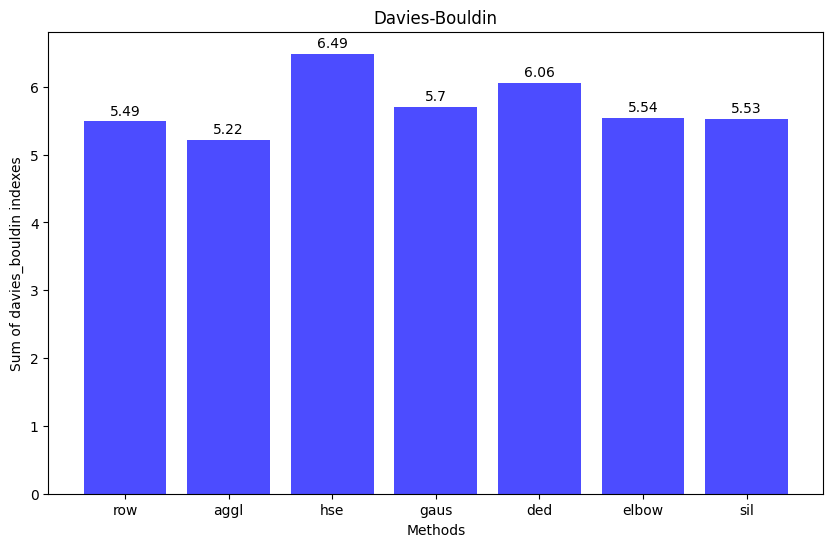

In [211]:
plot_comparison(dbi_sum, ['row', 'aggl', 'hse', 'gaus', 'ded', 'elbow', 'sil'])

In [212]:
import matplotlib.pyplot as plt

def plot_comparison_dunn(dunn_sums, methods):
    plt.figure(figsize=(10,6))

    bars = plt.bar(methods, dunn_sums, color='blue', alpha=0.7)
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

    plt.title("Dunn")
    plt.xlabel('Methods')
    plt.ylabel('Sum of Dunn idexes')

    plt.axhline(y=5, color='r', linestyle='--')
    plt.text(0.97, 1.02, 'Perfect value', verticalalignment='bottom', horizontalalignment='right', color='red', fontsize=15, transform=plt.gca().transAxes)

    plt.show()

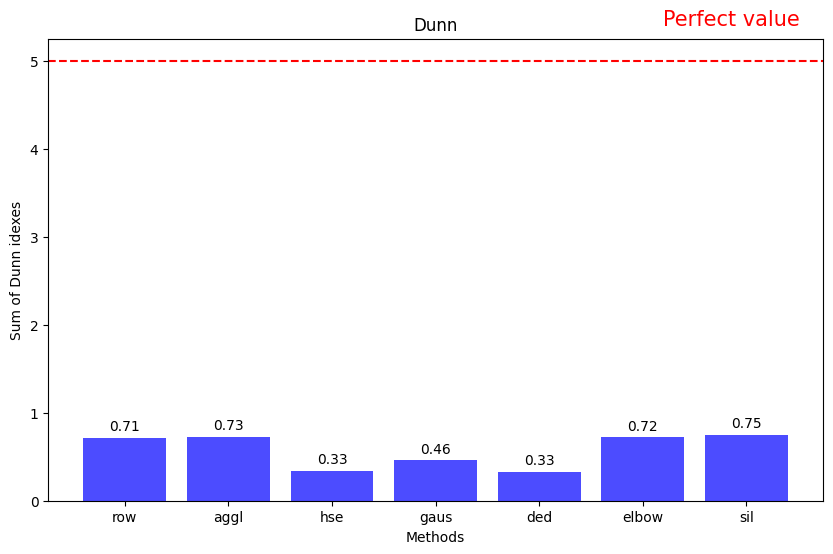

In [213]:
plot_comparison_dunn(dunn_sum, ['row', 'aggl', 'hse', 'gaus', 'ded', 'elbow', 'sil'])

In [214]:
import matplotlib.pyplot as plt

def plot_comparison_silhouette(silhouette_sums, methods):
    plt.figure(figsize=(10,6))

    bars = plt.bar(methods, silhouette_sums, color='blue', alpha=0.7)
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

    plt.title("Silhouette")
    plt.xlabel('Methods')
    plt.ylabel('Sum of Silhouette indexes')

    plt.axhline(y=5, color='r', linestyle='--')
    plt.text(0.97, 1.02, 'Perfect value', verticalalignment='bottom', horizontalalignment='right', color='red', fontsize=15, transform=plt.gca().transAxes)

    plt.show()

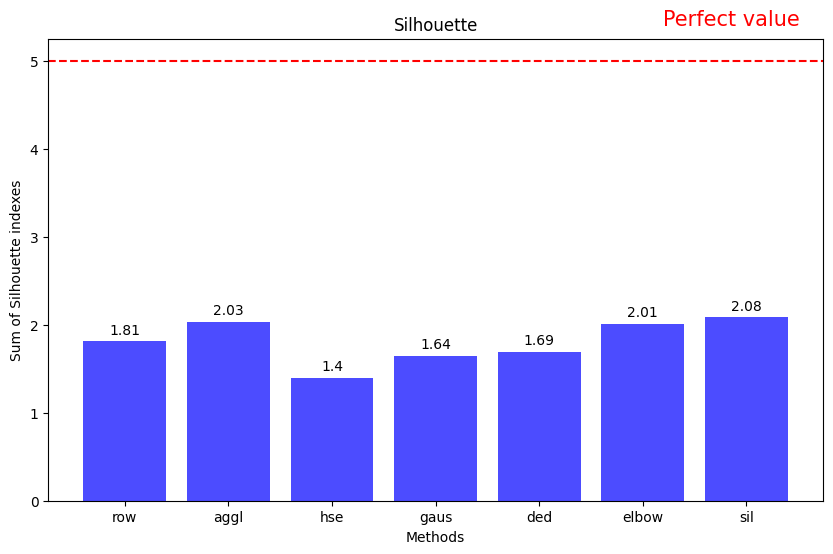

In [215]:
plot_comparison_silhouette(silhouette_sum, ['row', 'aggl', 'hse', 'gaus', 'ded', 'elbow', 'sil'])

---

In [216]:
df = pd.DataFrame({
    "Datasets": ["Wine", "Iris", "Landsat", "Magic", "Glass", "Total", "Sum of Errors"],
    "Instances": [177, 150, 1999, 19019, 213, '', ''],
    "Features": [13, 4, 36, 10, 9, '', ''],
    "True K": [3, 3, 6, 2, 2, 16, ''],
    "hse": [7, 3, 14, 6, 8, 38, 22],
    "row": [3, 2, 6, 13, 4, 28, 14],
    "gaus": [3, 9, 3, 3, 5, 23, 13],
    "aggl": [3, 2, 3, 2, 4, 14, 6],
    "ded": [2, 3, 2, 4, 4, 15, 9],
    "elbow": [3, 2, 3, 2, 3, 13, 5],
    "sil": [3, 2, 3, 2, 2, 12, 4]
})

df

,Datasets,Instances,Features,True K,hse,row,gaus,aggl,ded,elbow,sil
0,Wine,177,13,3,7,3,3,3,2,3,3
1,Iris,150,4,3,3,2,9,2,3,2,2
2,Landsat,1999,36,6,14,6,3,3,2,3,3
3,Magic,19019,10,2,6,13,3,2,4,2,2
4,Glass,213,9,2,8,4,5,4,4,3,2
5,Total,,,16,38,28,23,14,15,13,12
6,Sum of Errors,,,,22,14,13,6,9,5,4


In [217]:
df = pd.DataFrame({
    "Datasets": ["synth1", "synth2", "synth3", "synth4", "synth5", "Total", "Sum of Errors"],
    "Instances": [500, 1000, 750, 1500, 2000, '', ''],
    "Features": [2, 2, 2, 2, 2, '', ''],
    "True K": [3, 5, 4, 6, 7, 25, ''],
    "hse": [4, 6, 4, 8, 5, 27, 6],
    "row": [3, 5, 4, 4, 6, 22, 3],
    "gaus": [3, 5, 4, 7, 8, 27, 2],
    "aggl": [2, 3, 2, 2, 2, 11, 14],
    "ded": [19, 20, 20, 3, 2, 64, 55],
    "elbow": [2, 2, 2, 2, 2, 10, 15],
    "sil": [3, 5, 3, 5, 6, 22, 3]
})

df

,Datasets,Instances,Features,True K,hse,row,gaus,aggl,ded,elbow,sil
0,synth1,500,2,3,4,3,3,2,19,2,3
1,synth2,1000,2,5,6,5,5,3,20,2,5
2,synth3,750,2,4,4,4,4,2,20,2,3
3,synth4,1500,2,6,8,4,7,2,3,2,5
4,synth5,2000,2,7,5,6,8,2,2,2,6
5,Total,,,25,27,22,27,11,64,10,22
6,Sum of Errors,,,,6,3,2,14,55,15,3


In [218]:
df = pd.DataFrame({
    "Datasets": ["Wine", "Iris", "Landsat", "Magic", "Glass", "Total"],
    "hse": [1, 1, 23, 47, 1, 73],
    "row": [1, 1, 16, 344, 1, 363],
    "gaus": [1, 1, 6, 89, 1, 98],
    "aggl": [1, 1, 3, 32, 1, 38],
    "ded": [1, 1, 22, 133, 1, 158],
    "elbow": [1, 1, 5, 10, 1, 17],
    "sil": [1, 1, 5, 39, 1, 47]
})

df

,Datasets,hse,row,gaus,aggl,ded,elbow,sil
0,Wine,1,1,1,1,1,1,1
1,Iris,1,1,1,1,1,1,1
2,Landsat,23,16,6,3,22,5,5
3,Magic,47,344,89,32,133,10,39
4,Glass,1,1,1,1,1,1,1
5,Total,73,363,98,38,158,17,47


In [219]:
df = pd.DataFrame({
    "Datasets": ["synth1", "synth2", "synth3", "synth4", "synth5", "Total"],
    "hse": [1, 2, 2, 4, 3, 12],
    "row": [2, 3, 3, 5, 7, 20],
    "gaus": [1, 1, 1, 1, 1, 5],
    "aggl": [1, 1, 1, 2, 3, 8],
    "ded": [2, 3, 2, 5, 7, 19],
    "elbow": [1, 1, 1, 1, 1, 5],
    "sil": [1, 1, 1, 2, 3, 8]
})

df

,Datasets,hse,row,gaus,aggl,ded,elbow,sil
0,synth1,1,2,1,1,2,1,1
1,synth2,2,3,1,1,3,1,1
2,synth3,2,3,1,1,2,1,1
3,synth4,4,5,1,2,5,1,2
4,synth5,3,7,1,3,7,1,3
5,Total,12,20,5,8,19,5,8
